<a href="https://colab.research.google.com/github/Ashwin1234/ML_OCR_project1/blob/main/HandWritten_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import load_model
from google.colab.patches import cv2_imshow
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from gensim.models import Word2Vec

In [100]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [101]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [ ]:
#!unzip test_images.zip -d test_images

In [ ]:
!unzip data_1.zip -d data_1

In [102]:
test_image_dir = '/content/data_1/data/images'
img_size=32
train_images=[]
for j in os.listdir(test_image_dir):
  train_images.append(os.path.join(test_image_dir,j))
len(train_images)

1000

In [103]:
test_dir = '/content/data_1/data'
df=pd.read_excel(os.path.join(test_dir,'names.xlsx'))
first_row=df.columns.values
first_df=pd.DataFrame({'images':[first_row[0]],'labels':[first_row[1]]})
df.columns=['images','labels']
df=pd.concat([first_df,df],axis=0)
df.head()

,images,labels
0,TRAIN_00001.jpg,BALTHAZAR
0,TRAIN_00002.jpg,SIMON
1,TRAIN_00003.jpg,BENES
2,TRAIN_00004.jpg,LA LOVE
3,TRAIN_00005.jpg,DAPHNE


In [104]:
train_labels=df['labels']

In [105]:
train_X = []
train_Y = []
for image in train_images:
  train_X.append(image)
for label in train_labels:
  train_Y.append(label)

'TRAIN_00001.jpg'

In [106]:
!unzip NN_data_1.zip -d NN_data_1

Streaming output truncated to the last 5000 lines.
 extracting: NN_data_1/NN_data/Valid/F/184.jpg  
 extracting: NN_data_1/NN_data/Valid/F/185.jpg  
 extracting: NN_data_1/NN_data/Valid/F/186.jpg  
 extracting: NN_data_1/NN_data/Valid/F/187.jpg  
 extracting: NN_data_1/NN_data/Valid/F/188.jpg  
 extracting: NN_data_1/NN_data/Valid/F/189.jpg  
 extracting: NN_data_1/NN_data/Valid/F/19.jpg  
 extracting: NN_data_1/NN_data/Valid/F/190.jpg  
 extracting: NN_data_1/NN_data/Valid/F/191.jpg  
 extracting: NN_data_1/NN_data/Valid/F/192.jpg  
 extracting: NN_data_1/NN_data/Valid/F/193.jpg  
 extracting: NN_data_1/NN_data/Valid/F/194.jpg  
 extracting: NN_data_1/NN_data/Valid/F/195.jpg  
  inflating: NN_data_1/NN_data/Valid/F/2.jpg  
 extracting: NN_data_1/NN_data/Valid/F/20.jpg  
 extracting: NN_data_1/NN_data/Valid/F/21.jpg  
 extracting: NN_data_1/NN_data/Valid/F/22.jpg  
 extracting: NN_data_1/NN_data/Valid/F/23.jpg  
 extracting: NN_data_1/NN_data/Valid/F/24.jpg  
 extracting: NN_data_1/NN_

In [108]:
dir = '/content/NN_data_1/NN_data/Train'
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [110]:
val_dir = "/content/NN_data_1/NN_data/Valid"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [111]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [112]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [113]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y=LB.fit_transform(val_Y)

In [114]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [115]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [116]:
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)

(43718, 32, 32, 1)
(43718, 35)
(8172, 32, 32, 1)
(8172, 35)


In [117]:
train_Y.shape

(43718, 35)

In [118]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [120]:


model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0

In [121]:


model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])



In [122]:
history = model.fit(train_X,train_Y, epochs=10, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/10
1367/1367 [==============================] - 96s 70ms/step - loss: 1.6044 - accuracy: 0.5482 - val_loss: 0.5106 - val_accuracy: 0.8488
Epoch 2/10
1367/1367 [==============================] - 94s 69ms/step - loss: 0.4218 - accuracy: 0.8653 - val_loss: 0.4691 - val_accuracy: 0.8625
Epoch 3/10
1367/1367 [==============================] - 90s 66ms/step - loss: 0.3269 - accuracy: 0.8959 - val_loss: 0.4309 - val_accuracy: 0.8672
Epoch 4/10
1367/1367 [==============================] - 93s 68ms/step - loss: 0.2701 - accuracy: 0.9124 - val_loss: 0.3492 - val_accuracy: 0.8929
Epoch 5/10
1367/1367 [==============================] - 90s 66ms/step - loss: 0.2362 - accuracy: 0.9227 - val_loss: 0.3509 - val_accuracy: 0.8895
Epoch 6/10
1367/1367 [==============================] - 88s 64ms/step - loss: 0.2128 - accuracy: 0.9285 - val_loss: 0.3524 - val_accuracy: 0.8919
Epoch 7/10
1367/1367 [==============================] - 89s 65ms/step - loss: 0.1976 - accuracy: 0.9339 - val_loss: 0.3505 -

In [123]:
model.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                       
model_file.SetContentFile('model.h5')                       
model_file.Upload()     

In [124]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1tAt75DybJKJE7pEGyFoZMam_JUw6EZNr'})

In [125]:
file_obj = drive.CreateFile({'id': '1m_6KvvD1OUb30EF8muOo2AV-3Ub0oSJF'})                       
file_obj.GetContentFile('model.h5')
model=load_model('model.h5')

In [ ]:
#model_2=load_model('_model.h5')
#model_2.summary()

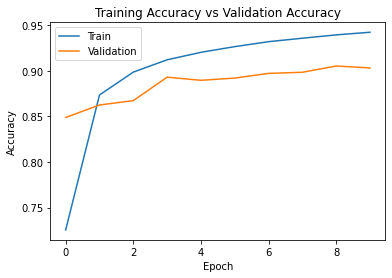

In [126]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

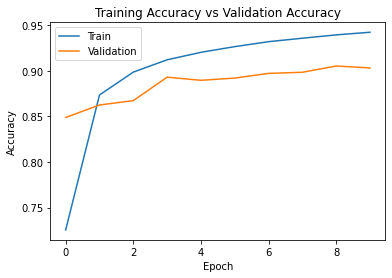

In [127]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [128]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [134]:
def get_letters(img):
    letters = []
    
    image = cv2.imread(img)
    cv2_imshow(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(gray)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 40 and cv2.contourArea(c) < 400:
            (x, y, w, h) = cv2.boundingRect(c)
           
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      
            if type(x)==np.str_ or type(y)==np.str_ or type(w)==np.str_ or type(h)==np.str_:
              continue
       
            roi = gray[y:y + h, x:x + w]
           

            thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
            thresh = thresh.astype("float32") / 255.0
            thresh = np.expand_dims(thresh, axis=-1)
            thresh = thresh.reshape(1,32,32,1)
            ypred = model.predict(thresh)
      
            ypred = LB.inverse_transform(ypred)
            [x] = ypred
            letters.append(x)
    cv2_imshow(image)
    return letters, image


In [130]:
def get_word(letters):
  return ' '.join(map(str,letters))


In [131]:
|dir = '/content/test_images/test_images'
test_images=[]
for j in os.listdir(dir):
  test_images.append(os.path.join(dir,j))

SyntaxError: ignored

In [135]:
def word2vec(word):
    from collections import Counter
    from math import sqrt

    # count the characters in word
    cw = Counter(word)
    # precomputes a set of the different characters
    sw = set(cw)
    # precomputes the "length" of the word vector
    lw = sqrt(sum(c*c for c in cw.values()))

    # return a tuple
    return cw, sw, lw

def cosdis(v1, v2):
    # which characters are common to the two words?
    common = v1[1].intersection(v2[1])
    # by definition of cosine distance we have
    return sum(v1[0][ch]*v2[0][ch] for ch in common)/v1[2]/v2[2]

In [136]:
#print(os.path.join(test_image_dir,df.iloc[0]['images']))
#get_letters(os.path.join(test_image_dir,df.iloc[0]['images']))

letters,image=get_letters(os.path.join(test_image_dir,df.iloc[6]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[6]['labels']))*100, "%")
#print(letters)

word is  6 N Q 5 S I M
accuracy of word mathcing is  26.958193300859605 %


In [137]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[5]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[5]['labels']))*100, "%")
#print(letters)

word is  L U I 1 F
accuracy of word mathcing is  29.277002188456 %


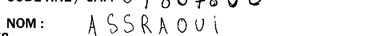

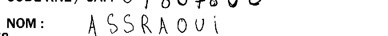

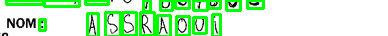

word is  V 6 7 V B S S K 1 H U V C U J W I V R
accuracy of word mathcing is  12.188552706720104 %


In [138]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[7]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[7]['labels']))*100, "%")
#print(letters)

In [139]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[8]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[8]['labels']))*100, "%")
#print(letters)

word is  1 6 4 L V V P P W
accuracy of word mathcing is  12.087344460380702 %


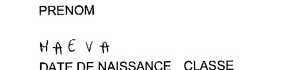

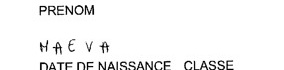

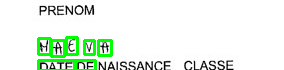

word is  M H M F N V M
accuracy of word mathcing is  21.597969886241554 %


In [140]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[9]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[9]['labels']))*100, "%")
#print(letters)

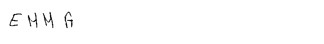

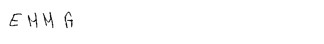

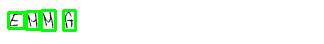

word is  F M M H
accuracy of word mathcing is  42.16370213557839 %


In [141]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[10]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[10]['labels']))*100, "%")
#print(letters)

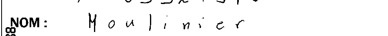

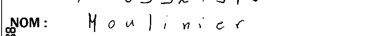

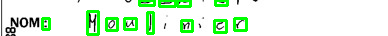

word is  2 H 0 M T J V R R C Y F
accuracy of word mathcing is  7.784989441615231 %


In [142]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[11]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[11]['labels']))*100, "%")
#print(letters)

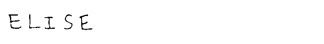

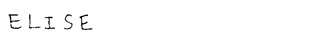

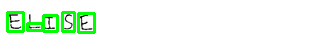

word is  5 L J 5 F
accuracy of word mathcing is  7.881104062391006 %


In [143]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[12]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[12]['labels']))*100, "%")
#print(letters)

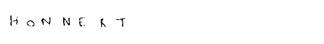

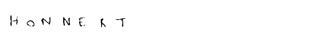

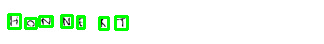

word is  H 0 N N F H T
accuracy of word mathcing is  34.035164682842066 %


In [144]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[13]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[13]['labels']))*100, "%")
#print(letters)

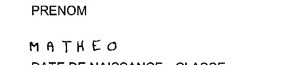

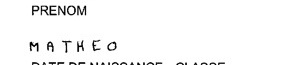

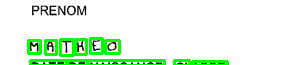

word is  M W M J N H M F 0 H W
accuracy of word mathcing is  18.556740475630136 %


In [145]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[14]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[14]['labels']))*100, "%")
#print(letters)

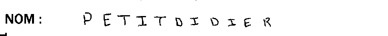

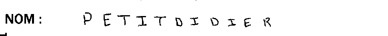

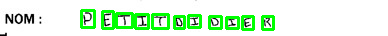

word is  P F J J J P J U I F K
accuracy of word mathcing is  9.251331131031607 %


In [146]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[15]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[15]['labels']))*100, "%")
#print(letters)

In [147]:
letters,image=get_letters(os.path.join(test_image_dir,df.iloc[16]['images']))
word=get_word(letters)
print("word is ",word)
print("accuracy of word mathcing is " ,cosdis(word2vec(word),word2vec(df.iloc[16]['labels']))*100, "%")
#print(letters)

word is  P 2 V L 5 N F
accuracy of word mathcing is  17.29171253112705 %
